    A script by AndresPDLR
    
    Data Source: https://www.imf.org/external/np/fin/data/rms_mth.aspx

<div class="alert alert-success">
**Requirements**

</div>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
plt.style.use('ggplot')
import math as mt
import datetime
import itertools
import networkx as nx
from imf_currencies_codes import *

<div class="alert alert-success">
**Functions**

</div>

In [2]:
def exchange_rate(rate0,rate1):
    ''' Measures the rate of depreciation (if < 0) or appreciation (if > 0) '''
    rv = (rate0 - rate1) / rate1
    return rv

In [3]:
def replace_comma(string):
    ''' It replaces comma within a string '''
    string = str(string)
    rv_string = string.replace(',', '')
    return rv_string

In [4]:
def covariance(list_1, list_2):
    ''' Calculates the covariance of two lists '''
    if len(list_1) == len(list_2):
        mean_1 = np.nansum(list_1) / len(list_1)
        mean_2 = np.nansum(list_2) / len(list_2)
        sum_rv = []
        for i in range(len(list_1)):
            product_rv = (list_1[i] - mean_1) * (list_2[i] - mean_1)
            sum_rv.append(product_rv)
        rv = np.nansum(sum_rv) / len(list_1)
        return rv
    else:
        print('Error: lists with different lengths!')    

In [5]:
def permutations(input_list, subset_size):
    ''' Creates a list of all possible permutations '''
    rv = []
    for subset in itertools.permutations(input_list, subset_size):
        rv.append(subset)
    return rv

In [6]:
def up_down(number):
    try:
        if number < 0:
            rv = -1
        elif number > 0:
            rv = 1
        else:
            rv = 0
        return rv
    except:
        return number

In [7]:
def dot_product(list_1, list_2):
    if len(list_1) == len(list_2):
        rv = []
        for x in range(len(list_1)):
            product = list_1[x] * list_2[x]
            rv.append(product)
        return np.nansum(rv)
    else:
        print('Error: lists with different lengths!')

In [8]:
def vector_norm(input_list):
    rv = []
    for x in range(len(input_list)):
        product = input_list[x] * input_list[x]
        rv.append(product)
    sum_rv = np.nansum(rv)
    return mt.sqrt(sum_rv)

In [9]:
def cosine_similarity(list_1, list_2):
    if len(list_1) == len(list_2):
        numerator = dot_product(list_1, list_2)
        denominator = vector_norm(list_1) * vector_norm(list_2)
        cos_theta = numerator / denominator
        return cos_theta
    else:
        print('Error: lists with different lengths!')

In [10]:
''' Defines the date as a string '''
date = datetime.datetime.now().isoformat()[0:10]

<div class="alert alert-success">
**Matrix M1**

</div>

Matrix M1 represents the raw data of currencies from IMF 

In [11]:
''' Calls the file into iPython '''
file = 'imf_currencies_{}.xls'.format(date)
M1 = pd.read_csv(file, sep = '\t', header = 0)

In [12]:
''' Adds code and country columns from imf_currencies_codes.py to M1 '''
codes = []
countries = []
currencies = []
for currency in M1['Currency']:
    currencies.append(currency)
    country = imf_currencies_codes[currency][0]
    code = imf_currencies_codes[currency][1]
    codes.append(code)
    countries.append(country)
M1['Codes'] = codes
M1['Countries'] = countries

In [13]:
''' Extracts dates as column names '''
exceptions = ['Currency', 'Codes', 'Countries']
dates = {}
index = 0
for colname in M1.columns:
    if colname not in exceptions:
        dates[index] = colname
        index += 1

In [14]:
''' Transforms format <xx,xxx.xx> into <xxxxx.xx> in the original pandas data frame '''
for date in dates.values():
    M1[date] = M1[date].apply(replace_comma)

In [15]:
''' Extracts the performance of every currency for every relevant date '''
performance = {}
index = 0
for currency in M1['Currency']:
    performance[currency] = {}
    for date in dates.values():
        rv = M1[date][index]
        real_rv = float(rv)
        if np.isnan(real_rv):
            pass
        else:
            performance[currency][date] = real_rv
    index += 1

In [16]:
''' Creates super_performance and day_periods '''
super_performance = {}
day_periods = {}
for x in range(len(M1)):
    currency = M1['Currency'][x]
    super_performance[currency] = {}
    for date_i, date in dates.items():
        if date_i == 0:
            pass
        else:
            date_0 = dates[date_i - 1]
            date_1 = dates[date_i]
            rate_t0 = float(M1[date_0][x])
            rate_t1 = float(M1[date_1][x])
            rate_change = (rate_t0 - rate_t1) / rate_t1
            day_period = date_0 + ' to ' + date_1
            day_periods[date_i] = day_period
            super_performance[currency][day_period] = rate_change

<div class="alert alert-success">
**Objects**

</div>

    M1                -> Raw with all currencies
    
    From matrix M1 we have built:

    currencies        -> List of currencies
    dates             -> Dictionary of dates len(dates) = m
    codes             -> List of currency codes 
    countries         -> List of countries
    performance       -> Dictionary of performance
    day_periods       -> Dictionary of day periods len(day_periods) = m - 1
    super_performance -> Dictionary of super performance
    
    M2                -> 

<div class="alert alert-success">
**Matrix M2**

</div>

In [17]:
''' Creates matrix M2 '''
M2 = pd.DataFrame({'Currencies': currencies})
for day_period in day_periods.values():
    rate_change_list = []
    for currency in currencies:
        rv = super_performance[currency][day_period]
        rate_change_list.append(rv)
    M2[day_period] = rate_change_list

In [18]:
XY = {} # Mean rate change & Variance rate change
for currency in currencies:
    code = imf_currencies_codes[currency][1]
    currency_super_performance = list(super_performance[currency].values())
    mean_change = np.nanmean(currency_super_performance)
    sigma_change = np.nanstd(currency_super_performance)
    XY[code] = (mean_change, sigma_change)

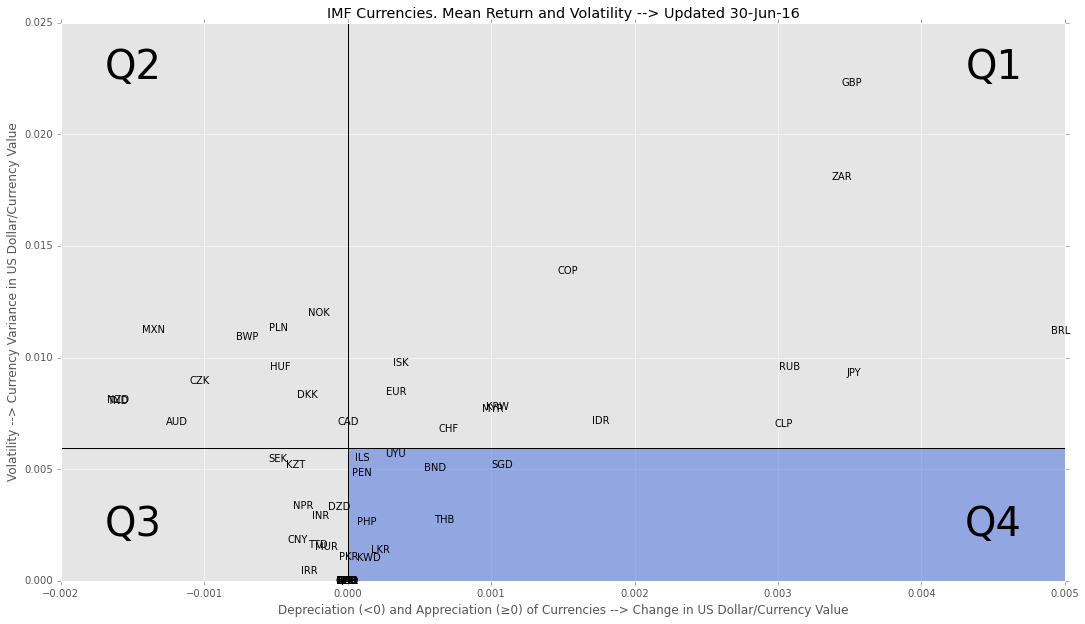

In [19]:
''' Plots '''
codes = []
Y = []
X = []
for code, xy in XY.items():
    codes.append(code)
    X.append(xy[0])
    Y.append(xy[1])
mean_y = np.nanmean(Y)
Q1 = []
Q2 = []
Q3 = []
Q4 = []
for code, xy in XY.items():
    if xy[0] >= 0 and xy[1] >= mean_y:
        Q1.append(code)
    elif xy[0] < 0 and xy[1] >= mean_y:
        Q2.append(code)
    elif xy[0] < 0 and xy[1] < mean_y:
        Q3.append(code)
    else:
        Q4.append(code)
fig = plt.figure(figsize=(18,10))
plt.title("IMF Currencies. Mean Return and Volatility --> Updated {}".format(date))
plt.xlabel("Depreciation (<0) and Appreciation (≥0) of Currencies --> Change in US Dollar/Currency Value")
plt.ylabel("Volatility --> Currency Variance in US Dollar/Currency Value")
plt.axvline(0, color = 'black', linestyle = 'solid', linewidth = 1)
plt.axhline(mean_y, color = 'black', linestyle = 'solid', linewidth = 1)
plt.plot(X, Y, 'o', c = 'black', markersize = .01)
for c, x, y in zip(XY.keys(), X, Y):
        plt.annotate(c, xy = (x, y), xytext = (0, 0), textcoords = 'offset points', ha = 'center', va = 'center')
axis = plt.gca()
axis.add_patch(patches.Rectangle((0, 0), 1, mean_y, color = 'RoyalBlue', alpha = .5))
TC = 'offset points'
AL = 'center'
plt.annotate('Q1', xy = (.0045, .023), xytext = (0, 0), textcoords = TC, ha = AL, va = AL, size = 40)
plt.annotate('Q2', xy = (-.0015, .023), xytext = (0, 0), textcoords = TC, ha = AL, va = AL, size = 40)
plt.annotate('Q3', xy = (-.0015, .0025), xytext = (0, 0), textcoords = TC, ha = AL, va = AL, size = 40)
plt.annotate('Q4', xy = (.0045, .0025), xytext = (0, 0), textcoords = TC, ha = AL, va = AL, size = 40)

In [20]:
Quadrants = [Q1, Q2, Q3, Q4]
index = 1
for q in Quadrants:
    print('Currencies in Quadrant Q{}:'.format(index), '\n', q, '\n\n')
    index += 1

Currencies in Quadrant Q1: 
 ['MYR', 'ZAR', 'CHF', 'COP', 'IDR', 'CLP', 'KRW', 'RUB', 'CAD', 'EUR', 'ISK', 'GBP', 'BRL', 'JPY'] 


Currencies in Quadrant Q2: 
 ['AUD', 'NZD', 'NOK', 'BWP', 'TND', 'PLN', 'CZK', 'DKK', 'HUF', 'MXN'] 


Currencies in Quadrant Q3: 
 ['INR', 'SEK', 'KZT', 'DZD', 'MUR', 'NPR', 'TTD', 'CNY', 'IRR'] 


Currencies in Quadrant Q4: 
 ['USD', 'SGD', 'KWD', 'PKR', 'THB', 'PHP', 'LKR', 'BND', 'ILS', 'BHD', 'UYU', 'SAR', 'AED', 'VEF', 'PEN', 'QAR', 'OMR', 'LYD'] 




In [21]:
''' Creates Cosine similarity given M2 '''
M2_cosine = pd.DataFrame({'Currencies': currencies})
for currency in currencies:
    rv = []
    currency_df = M2.loc[M2['Currencies'] == currency]
    currency_row = list(map(list, currency_df.values))[0][1:]
    for currency_2 in currencies:
        currency_2_df = M2.loc[M2['Currencies'] == currency_2]
        currency_2_row = list(map(list, currency_2_df.values))[0][1:]
        cov_c1_c2 = cosine_similarity(currency_row, currency_2_row)
        rv.append(cov_c1_c2)
    M2_cosine[currency] = rv

In [22]:
''' Calculates Network given a threshold starting from Cosine Similarity Matrix '''
all_similarities = []
for mean_variance in M2_cosine.mean(skipna=True):
    all_similarities.append(mean_variance)
threshold = np.nansum(all_similarities) / len(all_similarities)
network_cosine = []
for x in range(len(M2_cosine)):
    currency_row = M2_cosine['Currencies'][x]
    for currency_col in M2_cosine.columns:
        if currency_row != currency_col and currency_col != 'Currencies':
            if M2_cosine[currency_col][x] >= threshold and (currency_col, currency_row) not in network_cosine:
                network_cosine.append((currency_row, currency_col))
            else:
                pass
        else:
            pass

In [23]:
cosine_network_nodes = []
for node in network_cosine:
    origin = node[0]
    destiny = node[1]
    if origin not in cosine_network_nodes:
        cosine_network_nodes.append(origin)
    if destiny not in cosine_network_nodes:
        cosine_network_nodes.append(destiny)

In [24]:
''' Add the nodes '''
G_cosine = nx.Graph()
for node in cosine_network_nodes:
    G_cosine.add_node(node)

In [25]:
''' Add the edges '''
for node in network_cosine:
    G_cosine.add_edge(*node)

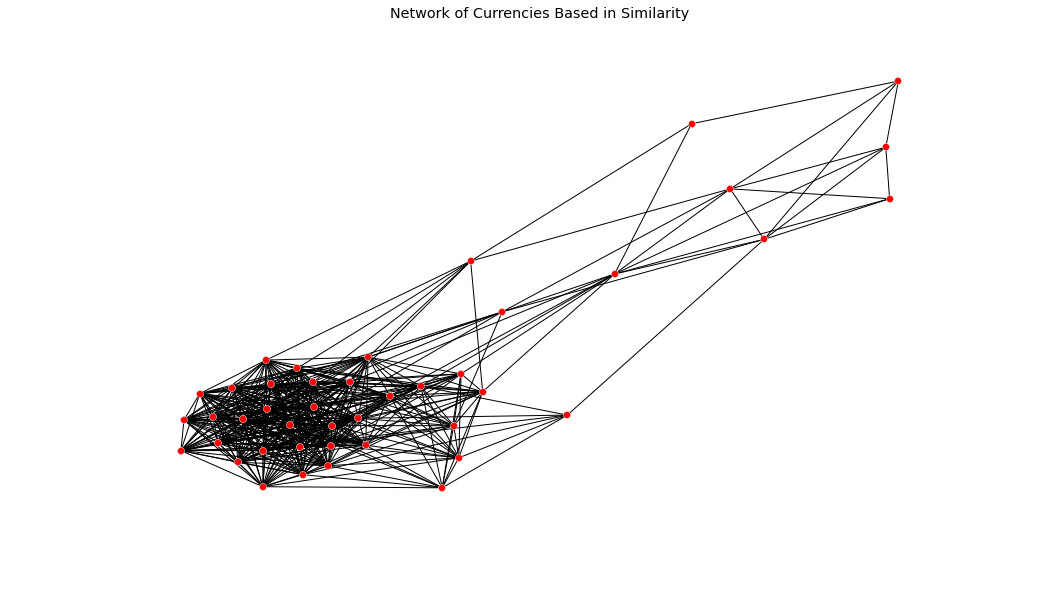

In [26]:
fig = plt.figure(figsize=(18,10))
plt.title('Network of Currencies Based in Similarity')
nx.draw(G_cosine, node_size = 50)

<div class="alert alert-success">
**Matrix M3**

</div>

In [27]:
''' Creates M3 '''
M3 = pd.DataFrame({'Currencies': currencies})
for currency in currencies:
    rv = []
    currency_df = M2.loc[M2['Currencies'] == currency]
    currency_row = list(map(list, currency_df.values))[0][1:]
    for currency_2 in currencies:
        currency_2_df = M2.loc[M2['Currencies'] == currency_2]
        currency_2_row = list(map(list, currency_2_df.values))[0][1:]
        cov_c1_c2 = covariance(currency_row, currency_2_row)
        rv.append(cov_c1_c2)
    M3[currency] = rv

In [28]:
''' Calculates Network given a threshold '''
all_variances = []
for mean_variance in M3.mean(skipna=True):
    all_variances.append(mean_variance)
threshold = np.nansum(all_variances) / len(all_variances)
network = []
for x in range(len(M3)):
    currency_row = M3['Currencies'][x]
    for currency_col in M3.columns:
        if currency_row != currency_col and currency_col != 'Currencies':
            if M3[currency_col][x] >= threshold and (currency_col, currency_row) not in network:
                network.append((currency_row, currency_col))
            else:
                pass
        else:
            pass

In [29]:
network_nodes = []
for node in network:
    origin = node[0]
    destiny = node[1]
    if origin not in network_nodes:
        network_nodes.append(origin)
    if destiny not in network_nodes:
        network_nodes.append(destiny)

In [30]:
''' Add the nodes '''
G = nx.Graph()
for node in network_nodes:
    G.add_node(node)

In [31]:
''' Add the edges '''
for node in network:
    G.add_edge(*node)

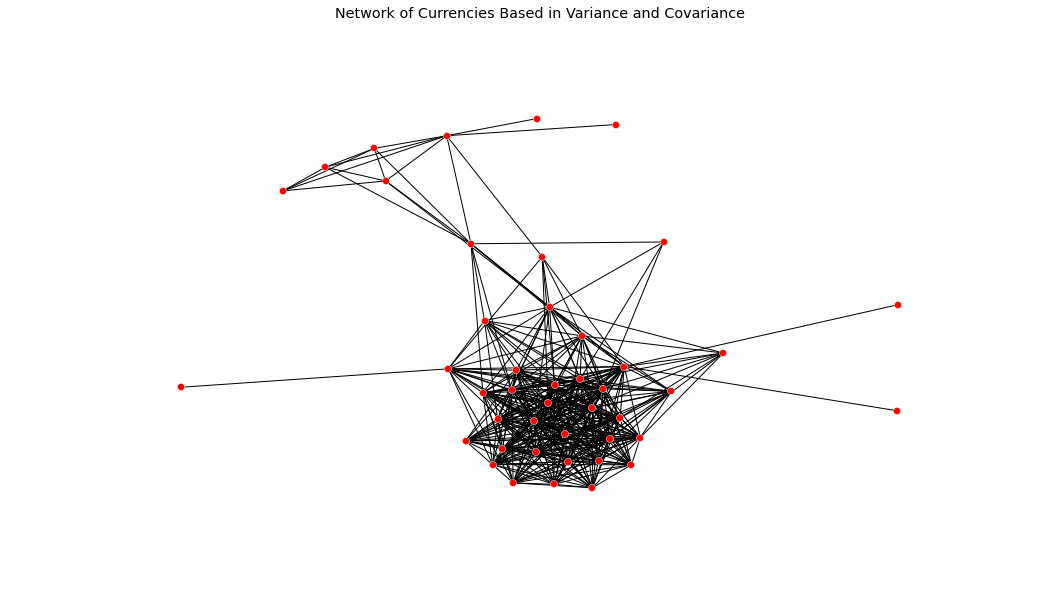

In [32]:
fig = plt.figure(figsize=(18,10))
plt.title('Network of Currencies Based in Variance and Covariance')
nx.draw(G, node_size = 50)

<div class="alert alert-success">
**Matrix M4**

</div>

In [33]:
M4 = pd.DataFrame({'Currencies': currencies})
for column in M2.columns:
    M4[column] = M2[column].apply(up_down)